# **Entrega 02** #

## **Predicción del caudal de un río usando Random Forest** ##

🎯 **Objetivo:**
Predecir el caudales de tres cuencas de regimenes diferentes.

**Fuente de datos**

[CR2_Center for Climate and resilience Research](https://www.cr2.cl/camels-cl/)

La base de datos CAMELS-CL (Catchment Attributes and Meteorology for Large Sample Studies, Chile Dataset) integra información física e hidro-meteorológica de cuencas de todo Chile.

In [35]:
import pandas as pd          # Manejo de datos en tablas (DataFrames)
import numpy as np           # Operaciones numéricas y matrices

import matplotlib.pyplot as plt  # Gráficos básicos
import seaborn as sns            # Gráficos estadísticos más bonitos

from sklearn.preprocessing import MinMaxScaler  # Normalización de datos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Métricas de evaluación

import torch                # Computación con tensores, base de PyTorch
import torch.nn as nn       # Construcción de redes neuronales
from torch.utils.data import DataLoader, TensorDataset, random_split  # Manejo de datos para entrenamiento

In [36]:
# Leer el archivo desde la subcarpeta 00_Inputs
df = pd.read_csv("00_Inputs/6027001.txt", sep="\t")

# Convertir la columna 'date' a tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Mostrar las primeras filas
print(df.head())

        date    Qmm    P          T     E
0 1989-04-01  0.132  0.0  13.329600  2.90
1 1989-04-02  0.130  0.0  11.261693  1.99
2 1989-04-03  0.126  0.0  11.619458  2.86
3 1989-04-04  0.118  0.0  11.993428  2.48
4 1989-04-05  0.116  0.0  13.440589  2.95


<Figure size 1200x500 with 0 Axes>

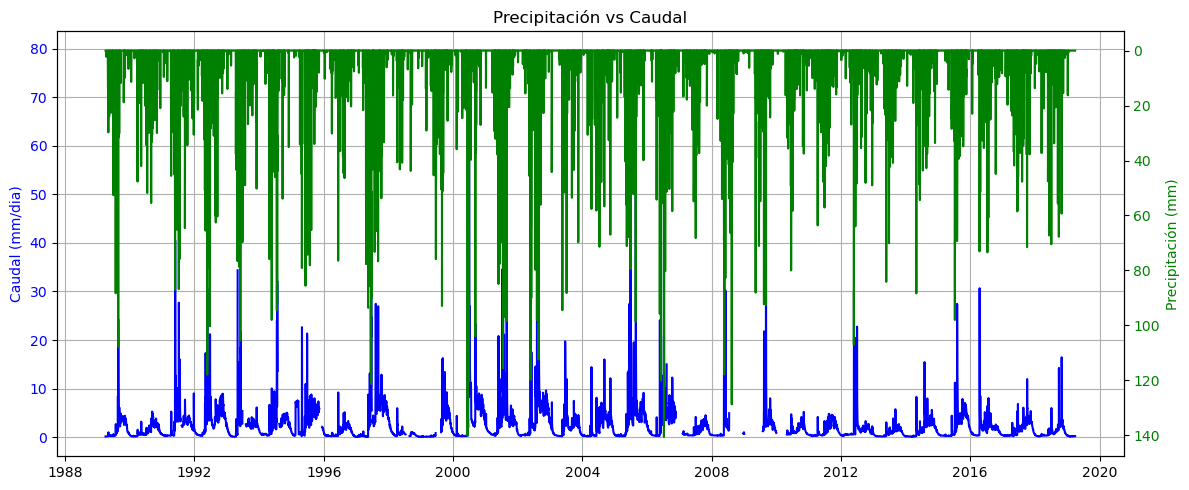

In [37]:
# VISUALIZACIÓN INICIAL

# VISUALIZACIÓN INICIAL: Precipitación y Caudal
plt.figure(figsize=(12, 5))
fig, ax1 = plt.subplots(figsize=(12, 5))

# Caudal
ax1.plot(df['date'], df['Qmm'], color='blue', label='Caudal')
ax1.set_ylabel('Caudal (mm/dia)', color='blue')  # Ajusta unidad si es necesario
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Precipitación vs Caudal')
ax1.grid(True)

# Precipitación
ax2 = ax1.twinx()
ax2.plot(df['date'], df['P'], color='green', label='Precipitación')
ax2.set_ylabel('Precipitación (mm)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.invert_yaxis()  # Para mostrar la precipitación como hietograma

plt.tight_layout()
plt.show()

In [38]:
df = df.dropna()   # Borramos datos NA
df.isna().sum()    # Nos aseguramos que no haya ningún valor nulo.

date    0
Qmm     0
P       0
T       0
E       0
dtype: int64

Fold 1:
  RMSE:  2.639
  R²:    0.448
  PBIAS: -9.30%
Fold 2:
  RMSE:  3.753
  R²:    0.498
  PBIAS: -26.55%
Fold 3:
  RMSE:  2.830
  R²:    0.602
  PBIAS: 6.48%
Fold 4:
  RMSE:  1.940
  R²:    0.251
  PBIAS: 73.33%
Fold 5:
  RMSE:  1.415
  R²:    0.524
  PBIAS: 31.19%

RMSE promedio (CV):  2.516 ± 0.799
R² promedio (CV):    0.465 ± 0.118
PBIAS promedio (CV): 15.03% ± 34.79%

Evaluación final en Validación:
RMSE:  1.141
R²:    0.858
PBIAS: 22.79%

Evaluación final en Test:
RMSE:  1.510
R²:    0.413
PBIAS: 42.56%


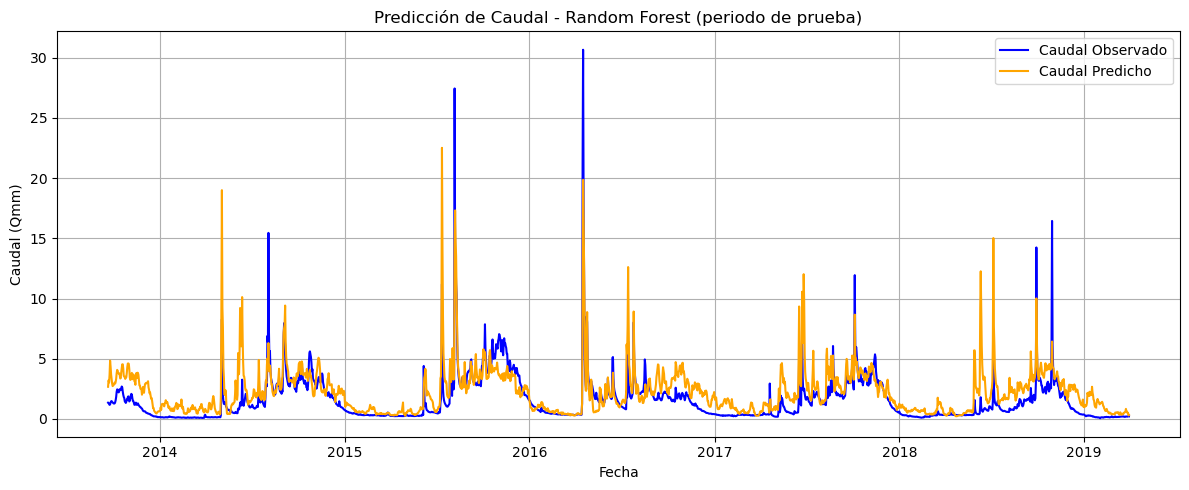

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# ----------------------------------
# 0. Crear retardos de P, T, E
# ----------------------------------
lags = 10
for var in ['P', 'T', 'E']:
    for lag in range(1, lags+1):
        df[f'{var}_lag{lag}'] = df[var].shift(lag)

# Crear lags acumulados (por ejemplo, 3 y 5 días hacia atrás)
for var in ['P', 'E']:
    for window in [3, 5]:
        df[f'{var}_sum{window}'] = df[var].shift(1).rolling(window=window).sum()

df = df.dropna().reset_index(drop=True)  # eliminar filas con NaNs por los lags

# ----------------------------------
# 1. Normalización de los datos
# ----------------------------------
predictor_vars = (
    ['P', 'T', 'E'] +
    [f'{v}_lag{l}' for v in ['P', 'T', 'E'] for l in range(1, lags+1)] +
    [f'{v}_sum{w}' for v in ['P', 'E'] for w in [3, 5]]
)
features = ['Qmm'] + predictor_vars

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

scaler_Q = MinMaxScaler()
df_scaled_Q = scaler_Q.fit_transform(df[['Qmm']])

X = df_scaled[:, 1:]      # variables predictoras (sin Qmm)
y = df_scaled_Q[:, 0]     # objetivo

# ----------------------------------
# 2. Validación cruzada temporal
# ----------------------------------
tscv = TimeSeriesSplit(n_splits=5)

def pbias(obs, sim):
    return 100.0 * np.sum(sim - obs) / np.sum(obs)

rmse_scores = []
r2_scores = []
pbias_scores = []

fold = 1
for train_index, val_index in tscv.split(X):
    print(f"Fold {fold}:")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='sqrt',
        bootstrap=True,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)

    # Invertir escalado para interpretación
    y_val_pred_inv = scaler_Q.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
    y_val_true_inv = scaler_Q.inverse_transform(y_val.reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(y_val_true_inv, y_val_pred_inv))
    r2 = r2_score(y_val_true_inv, y_val_pred_inv)
    pbias_val = pbias(y_val_true_inv, y_val_pred_inv)

    print(f"  RMSE:  {rmse:.3f}")
    print(f"  R²:    {r2:.3f}")
    print(f"  PBIAS: {pbias_val:.2f}%")

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    pbias_scores.append(pbias_val)

    fold += 1

print(f"\nRMSE promedio (CV):  {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}")
print(f"R² promedio (CV):    {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"PBIAS promedio (CV): {np.mean(pbias_scores):.2f}% ± {np.std(pbias_scores):.2f}%")

# ----------------------------------
# 3. Entrenamiento final en todo el set de entrenamiento + validación
# ----------------------------------
train_val_end = int(0.8 * len(X))
X_trainval = X[:train_val_end]
y_trainval = y[:train_val_end]
X_test = X[train_val_end:]
y_test = y[train_val_end:]

model_final = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

model_final.fit(X_trainval, y_trainval)

# ----------------------------------
# Evaluación del modelo final en Validación
# ----------------------------------
train_end = int(0.6 * len(X))
X_val_final = X[train_end:train_val_end]
y_val_final = y[train_end:train_val_end]

y_val_pred_final = model_final.predict(X_val_final)
y_val_pred_final_inv = scaler_Q.inverse_transform(y_val_pred_final.reshape(-1, 1)).flatten()
y_val_true_final_inv = scaler_Q.inverse_transform(y_val_final.reshape(-1, 1)).flatten()

rmse_val_final = np.sqrt(mean_squared_error(y_val_true_final_inv, y_val_pred_final_inv))
r2_val_final = r2_score(y_val_true_final_inv, y_val_pred_final_inv)
pbias_val_final = pbias(y_val_true_final_inv, y_val_pred_final_inv)

print("\nEvaluación final en Validación:")
print(f"RMSE:  {rmse_val_final:.3f}")
print(f"R²:    {r2_val_final:.3f}")
print(f"PBIAS: {pbias_val_final:.2f}%")

# ----------------------------------
# Evaluación final en Test
# ----------------------------------
y_test_pred = model_final.predict(X_test)
y_test_pred_inv = scaler_Q.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test_true_inv = scaler_Q.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse_test = np.sqrt(mean_squared_error(y_test_true_inv, y_test_pred_inv))
r2_test = r2_score(y_test_true_inv, y_test_pred_inv)
pbias_test = pbias(y_test_true_inv, y_test_pred_inv)

print("\nEvaluación final en Test:")
print(f"RMSE:  {rmse_test:.3f}")
print(f"R²:    {r2_test:.3f}")
print(f"PBIAS: {pbias_test:.2f}%")

# ----------------------------------
# 4. Gráfico resultados (test)
# ----------------------------------
plt.figure(figsize=(12,5))
plt.plot(df['date'].iloc[train_val_end:], y_test_true_inv, label='Caudal Observado', color='blue')
plt.plot(df['date'].iloc[train_val_end:], y_test_pred_inv, label='Caudal Predicho', color='orange')
plt.title('Predicción de Caudal - Random Forest (periodo de prueba)')
plt.xlabel('Fecha')
plt.ylabel('Caudal (Qmm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# ----------------------------------
# Cálculo de métricas solo para Qmm observados > percentil 0.95
# ----------------------------------
percentil_95 = np.percentile(y_test_true_inv, 95)
mask_extremos = y_test_true_inv > percentil_95

y_obs_extremos = y_test_true_inv[mask_extremos]
y_pred_extremos = y_test_pred_inv[mask_extremos]

rmse_extremos = np.sqrt(mean_squared_error(y_obs_extremos, y_pred_extremos))
r2_extremos = r2_score(y_obs_extremos, y_pred_extremos)
pbias_extremos = pbias(y_obs_extremos, y_pred_extremos)

print("\nEvaluación en Test solo para Qmm > percentil 95:")
print(f"RMSE:  {rmse_extremos:.3f}")
print(f"R²:    {r2_extremos:.3f}")
print(f"PBIAS: {pbias_extremos:.2f}%")


Evaluación en Test solo para Qmm > percentil 95:
RMSE:  3.594
R²:    0.292
PBIAS: -14.33%


Explicando la predicción para el valor máximo observado del test (índice #939)
Caudal observado: 30.664 mm/día
Caudal predicho:  19.856 mm/día
Fecha: 2016-04-16 00:00:00


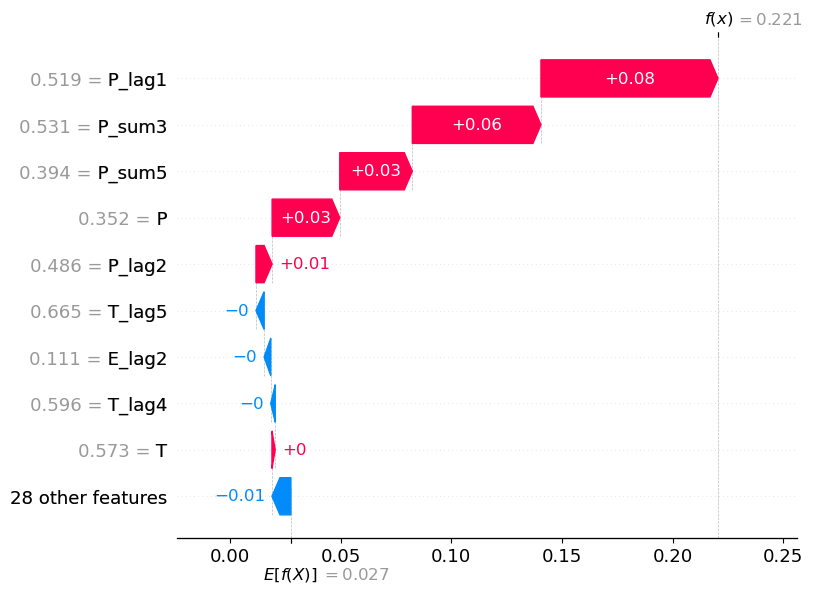

In [45]:
import shap
import numpy as np

# Inicializar el explicador SHAP para modelos tree-based como Random Forest
explainer = shap.Explainer(model, X_train, feature_names=predictor_vars)

# Obtener el índice del valor máximo observado en test
idx_max = np.argmax(y_test_true_inv)

# Calcular desde qué índice parte el set de validación/test
val_start = len(df) - len(y_test_true_inv)  # o usa tu lógica original si es distinta

print(f"Explicando la predicción para el valor máximo observado del test (índice #{idx_max})")
print(f"Caudal observado: {y_test_true_inv[idx_max]:.3f} mm/día")
print(f"Caudal predicho:  {y_test_pred_inv[idx_max]:.3f} mm/día")
print(f"Fecha: {df['date'].iloc[val_start + idx_max]}")

# Calcular los valores SHAP solo para ese punto
shap_values_single = explainer(X_test[idx_max:idx_max+1])

# Mostrar gráfico de fuerza (fuerza de cada variable para esa predicción)
shap.plots.waterfall(shap_values_single[0], max_display=10)

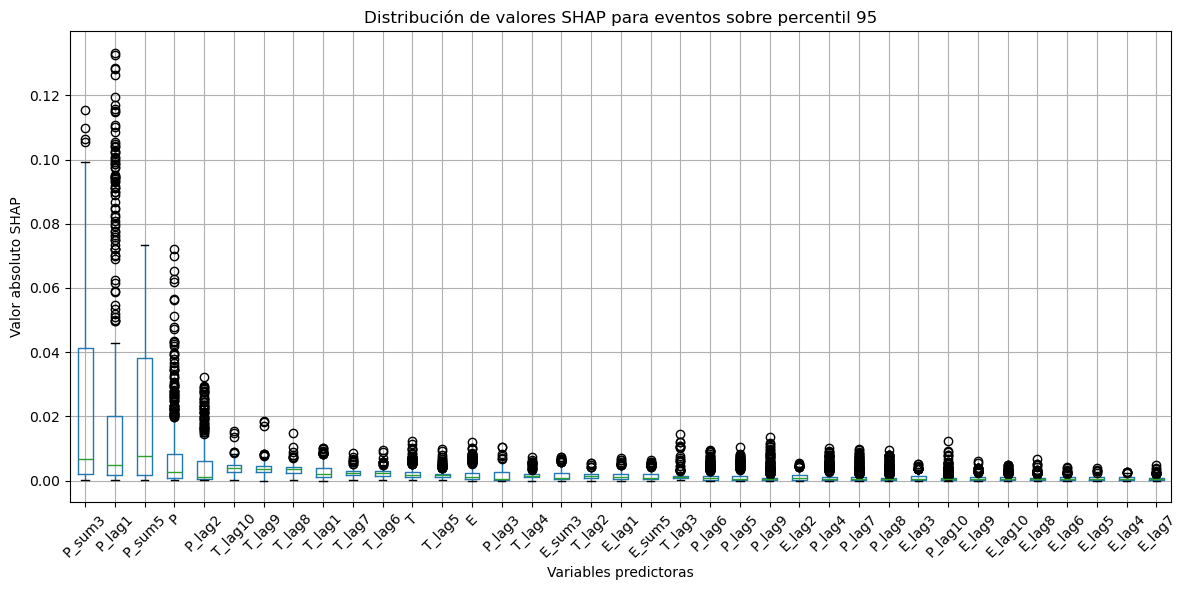

In [46]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir umbral para eventos extremos
umbral_95 = np.percentile(y, 95)
X_extremos = X[y >= umbral_95]

# Calcular valores SHAP para eventos extremos
explainer = shap.TreeExplainer(model)
shap_values_extremos = explainer.shap_values(X_extremos)

# Convertir a DataFrame
shap_df = pd.DataFrame(shap_values_extremos, columns=predictor_vars)

# Importancia media absoluta
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

# Ordenar para graficar
shap_df_ordered = shap_df[mean_abs_shap.index]

# Graficar
plt.figure(figsize=(12,6))
shap_df_ordered.abs().boxplot(rot=45, grid=True)
plt.title('Distribución de valores SHAP para eventos sobre percentil 95')
plt.ylabel('Valor absoluto SHAP')
plt.xlabel('Variables predictoras')
plt.tight_layout()
plt.show()